In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### 1.Data preparetion for Time Series Data

In [4]:
df_sales=pd.read_excel('C:/datalake/project_retail/master_dataset.xlsx', sheet_name='demand_data',encoding = 'unicode_escape')
df_sales['Month'] =df_sales['Month'].astype(str)
df_sales['Month']= df_sales["Month"].str.split(" ", n = 1, expand = True) 
df_sales['Month']=pd.to_datetime(df_sales['Month'])
df_sales.set_index('Month',inplace=True)
df_sales

,Milk Production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


### 2.Visualize Time Series Data

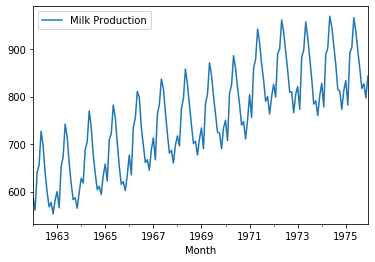

In [5]:
df_sales.plot()

### 3.Testing Stationarity of Data

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
test_result=adfuller(df_sales['Milk Production'])

In [8]:
# dk fullar test for stationarity

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adfuller_test(df_sales['Milk Production'])

ADF Test Statistic : -1.3038115874221294
p-value : 0.6274267086030316
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### rejected null hypothesis (>0.05)

In [10]:
df_sales['Sales First Difference'] = df_sales['Milk Production'] - df_sales['Milk Production'].shift(1)
df_sales.head(3)

,Milk Production,Sales First Difference
Month,,
1962-01-01,589,NaN
1962-02-01,561,-28.0
1962-03-01,640,79.0


In [11]:
df_sales['Milk Production'].shift(1)
df_sales.head(3)

,Milk Production,Sales First Difference
Month,,
1962-01-01,589,NaN
1962-02-01,561,-28.0
1962-03-01,640,79.0


In [12]:
df_sales['Seasonal First Difference']=df_sales['Milk Production']-df_sales['Milk Production'].shift(4)

In [13]:
df_sales.head(4)

,Milk Production,Sales First Difference,Seasonal First Difference
Month,,,
1962-01-01,589,NaN,NaN
1962-02-01,561,-28.0,NaN
1962-03-01,640,79.0,NaN
1962-04-01,656,16.0,NaN


In [14]:
## Again test dickey fuller test
adfuller_test(df_sales['Seasonal First Difference'].dropna())

ADF Test Statistic : -3.0969072216395346
p-value : 0.02678291617128674
#Lags Used : 11
Number of Observations Used : 152
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


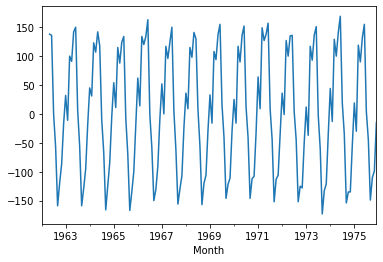

In [15]:
df_sales['Seasonal First Difference'].plot()

### Auto regressive model

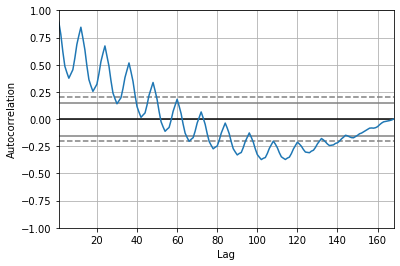

In [16]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_sales['Milk Production'])
plt.show()

In [21]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [22]:
model=ARIMA(df_sales['Milk Production'],order=(1,1,1))
model_fit=model.fit()

In [23]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Milk Production   No. Observations:                  167
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -873.331
Method:                       css-mle   S.D. of innovations             45.176
Date:                Wed, 27 May 2020   AIC                           1754.662
Time:                        10:08:18   BIC                           1767.134
Sample:                    02-01-1962   HQIC                          1759.724
                         - 12-01-1975                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.5417      3.874      0.398      0.691      -6.052       9.135
ar.L1.D.Milk Production     0.3873      0.249      1.555      0.122      -0.101       0.875
ma.L1.D.Milk Production    -0.3203      0.246     -1.301      0.195      -0.803       0.162
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5821           +0.0000j            2.5821            0.0000
MA.1            3.1218           +0.0000j            3.1218            0.0000
-----------------------------------------------------------------------------
"""

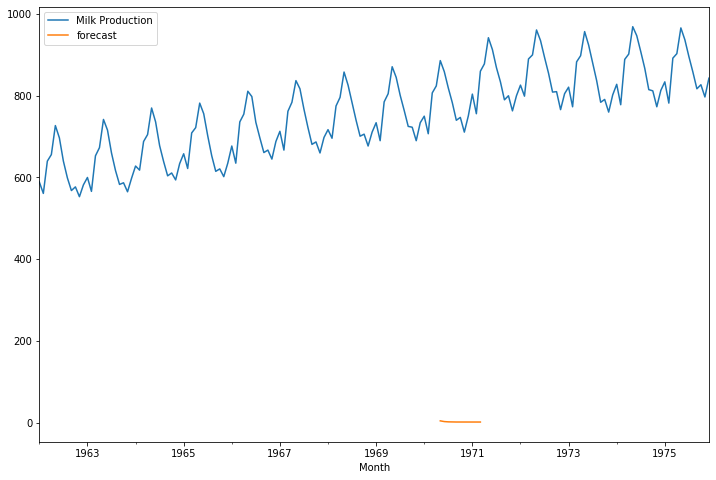

In [24]:
df_sales['forecast']=model_fit.predict(start=100,end=110,dynamic=True)
df_sales[['Milk Production','forecast']].plot(figsize=(12,8))

In [25]:
import statsmodels.api as sm

In [26]:
model=sm.tsa.statespace.SARIMAX(df_sales['Milk Production'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

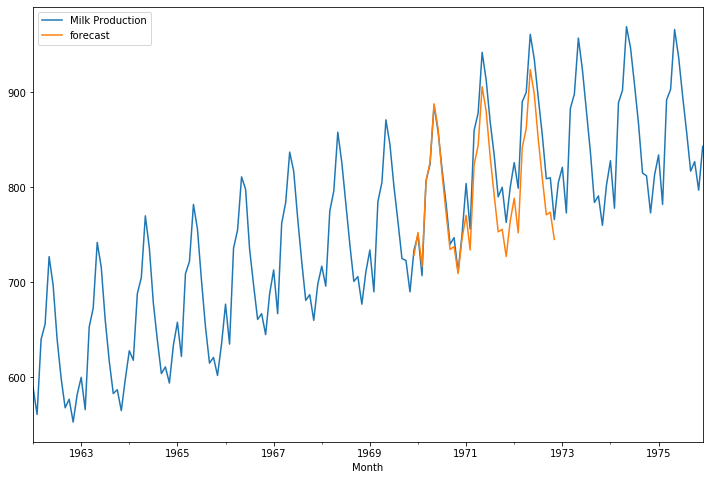

In [27]:
df_sales['forecast']=results.predict(start=95,end=130,dynamic=True)
df_sales[['Milk Production','forecast']].plot(figsize=(12,8))

In [28]:
df_sales.tail(5)

,Milk Production,Sales First Difference,Seasonal First Difference,forecast
Month,,,,
1975-08-01,858,-38.0,-45.0,NaN
1975-09-01,817,-41.0,-149.0,NaN
1975-10-01,827,10.0,-110.0,NaN
1975-11-01,797,-30.0,-99.0,NaN
1975-12-01,843,46.0,-15.0,NaN


In [29]:
from pandas.tseries.offsets import DateOffset
future_dates=pd.date_range(start='1/1977', end='9/1978',freq= pd.offsets.MonthBegin() )
future_dates

DatetimeIndex(['1977-01-01', '1977-02-01', '1977-03-01', '1977-04-01',
               '1977-05-01', '1977-06-01', '1977-07-01', '1977-08-01',
               '1977-09-01', '1977-10-01', '1977-11-01', '1977-12-01',
               '1978-01-01', '1978-02-01', '1978-03-01', '1978-04-01',
               '1978-05-01', '1978-06-01', '1978-07-01', '1978-08-01',
               '1978-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [31]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_sales.columns)
future_datest_df.sample(5)

,Milk Production,Sales First Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN
1978-07-01,NaN,NaN,NaN,NaN
1977-02-01,NaN,NaN,NaN,NaN
1978-05-01,NaN,NaN,NaN,NaN
1978-08-01,NaN,NaN,NaN,NaN


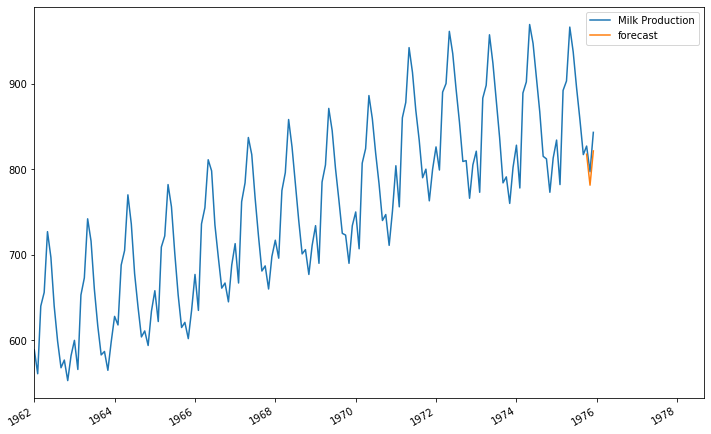

In [32]:
future_df=pd.concat([df_sales,future_datest_df])
future_df['forecast'] = results.predict(start = 165, end = 170, dynamic= True)  
future_df[['Milk Production','forecast']].plot(figsize=(12, 8))